In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [6]:
# Load CIFAR-10 dataset and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [7]:
# Define the DenseNet model for fine-tuning
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



# model = keras.models.Sequential()
# model.add(base_model)
# model.add(keras.layers.Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the validation set for monitoring
batch_size = 256
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
176/176 [==============================] - 36s 116ms/step - loss: 1.0507 - accuracy: 0.6548 - val_loss: 4.9184 - val_accuracy: 0.3780
Epoch 2/20
176/176 [==============================] - 19s 106ms/step - loss: 0.5522 - accuracy: 0.8139 - val_loss: 3.8560 - val_accuracy: 0.6008
Epoch 3/20
176/176 [==============================] - 19s 109ms/step - loss: 0.3885 - accuracy: 0.8684 - val_loss: 0.7298 - val_accuracy: 0.8084
Epoch 4/20
176/176 [==============================] - 19s 107ms/step - loss: 0.2863 - accuracy: 0.9027 - val_loss: 2.0529 - val_accuracy: 0.7550
Epoch 5/20
176/176 [==============================] - 19s 107ms/step - loss: 0.2189 - accuracy: 0.9241 - val_loss: 1.0453 - val_accuracy: 0.7592
Epoch 6/20
176/176 [==============================] - 19s 107ms/step - loss: 0.1773 - accuracy: 0.9408 - val_loss: 0.7883 - val_accuracy: 0.8182
Epoch 7/20
176/176 [==============================] - 19s 107ms/step - loss: 0.1477 - accuracy: 0.9515 - val_loss: 0.8575 - val_ac

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

40/40 [==============================] - 1s 21ms/step - loss: 1.0550 - accuracy: 0.8049
Test Loss: 1.054962396621704
Test Accuracy: 0.8048999905586243


In [9]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

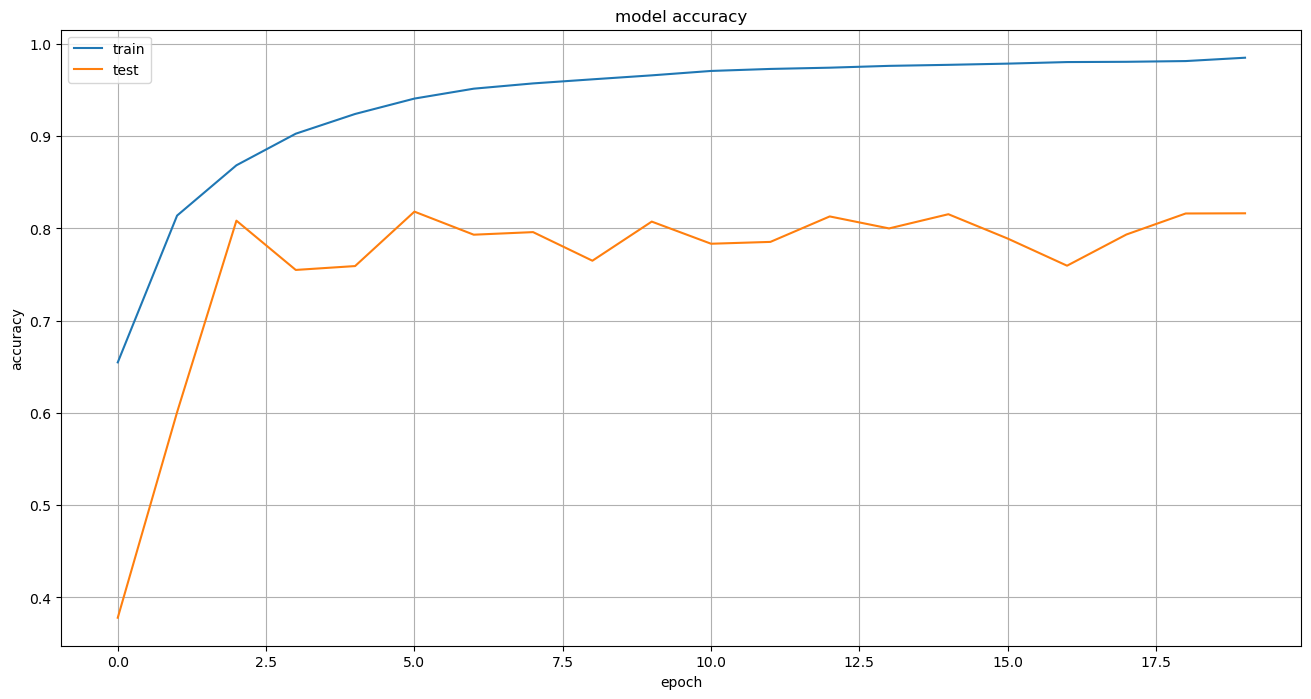

In [10]:
plothist(history)